In [1]:
import jax
# Set JAX to use CPU as the default device
jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import electric_fit as ef



# Configure JAX for 64-bit precision
jax.config.update("jax_enable_x64", True)

# Print JAX configuration info
print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print(f"Available devices: ")
for d in jax.devices():
    print(f"    Device: {d}, platform: {d.platform}, device_kind: {d.device_kind}, id: {d.id}")
print(f"64-bit precision enabled: {jax.config.jax_enable_x64}")


JAX version: 0.7.1
JAX backend: cpu
Available devices: 
    Device: TFRT_CPU_0, platform: cpu, device_kind: cpu, id: 0
64-bit precision enabled: True


In [2]:

Nf = 10 #frequencies
Np = 50 # sku pixes
Nx = Np//2 # num prods
Ns = Nf*Np # total sky points
Nd = Nf*Nx # total data points

ar = np.linspace (-1,1,Np)
far = np.linspace (-1,1,Nf)
S = jnp.zeros((Ns,Ns))
for i in range(Nf):
    for ip in range(Nf):
        for j in range(Np):
            ndx = i*Np + j
            ndxp = ip*Np + j
            # diaogonal in pixels and correlated in frequency
            val = np.exp(-0.5*ar[j]**2/(0.5**2)) * jnp.exp(-0.5*(ar[i]-ar[ip])**2/0.1**2)            
            S.at[ndx,ndxp].set(val)
            S = S.at[ndx, ndxp].set(val)

P = jnp.zeros((Nd,Ns))
# this projection operations is block diagonal in frequency
P_i = jnp.zeros((Nx,Np))
for i in range(Nx):
    P_i = P_i.at[i,2*i].set(1.0)
    P_i = P_i.at[i,2*i+1].set(1.0)
for i in range(Nf):
    P = P.at[i*Nx:(i+1)*Nx, i*Np:(i+1)*Np].set(P_i)

m_true = far**2
Ndiag = 0.1*jnp.ones(Nd)

In [3]:
def Ps(s):            # y = P @ s     (block-diagonal over frequency)
    # we implement brute force
    return P @ s


# S: R^{Ns} -> R^{Ns}
def S_op(v):          # y = S @ v     (matrix-free)
    # we implement brute force for testing
    return S @ v


# Dm: R^{Nf} -> R^{Nd}
def Dm(m):            # y = Dcal @ m  (e.g., per-frequency constant replicated to N_x samples)
    return jnp.repeat(m, Nx)

def precond(v):
    return v/jnp.diag(P @ S @ P.T+ Ndiag)  # Jacobi preconditioner

In [4]:
#new generate data vecor
def generate_data(m_true):
    s_true = jax.random.multivariate_normal(jax.random.PRNGKey(3), jnp.zeros(Ns), S)
    d = Ps(s_true) + Dm(m_true) + jax.random.normal(jax.random.PRNGKey(4), (Nd,)) * jnp.sqrt(Ndiag)
    return d


d = generate_data(m_true)

In [5]:
# now we materialize them using jax magic. This ofc will not work for large problems
P_, S_, Dm_ = ef.materialize_small_mats(Ps, S_op, Dm, Ns, Nd, Nf)
print(jnp.allclose(P, P_))
print(jnp.allclose(S, S_))
#print(jnp.allclose(Dm, Dm_))

True
True


In [6]:
m_hat, C = ef.bruteforce_gls(d, P, S, Dm_, Ndiag)

In [7]:
m_hat_s, C_s = ef.solve_m_and_cov(d, Ns, Nd, Nf, Ps, S_op, Dm, Ndiag, tol=1e-6, maxiter=500, precond=precond)

In [8]:
print (m_hat_s)

[ 1.11195308  0.69259639  0.2973155   0.02136793 -0.17844214 -0.05475622
  0.08256856  0.30689214  0.69307921  0.86429795]


chi2: 7.2533878446570395 7.253399419828081


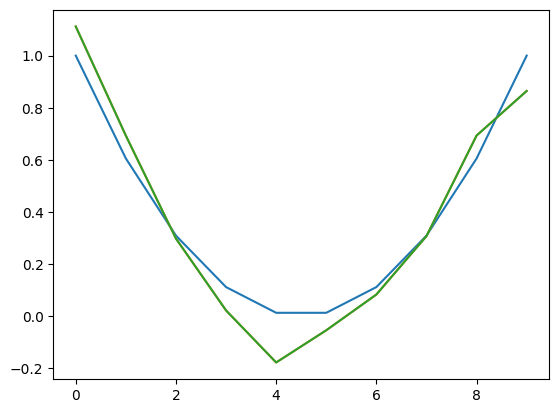

In [9]:
plt.plot(m_true, label="true")
plt.plot(m_hat, label="recovered")
plt.plot(m_hat_s, label="recovered iterative")
chi2 = jnp.sum((m_hat - m_true) @ jnp.linalg.inv(C) @ (m_hat - m_true))
chi2_s = jnp.sum((m_hat_s - m_true) @ jnp.linalg.inv(C_s) @ (m_hat_s - m_true))
print ("chi2:", chi2, chi2_s)

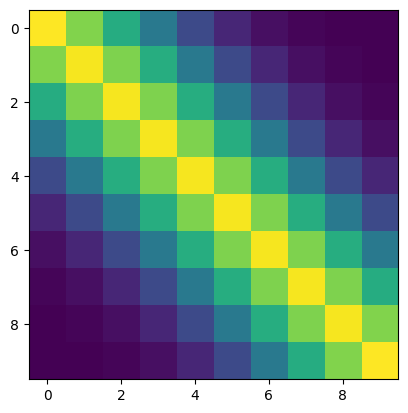

In [10]:
plt.imshow(C)

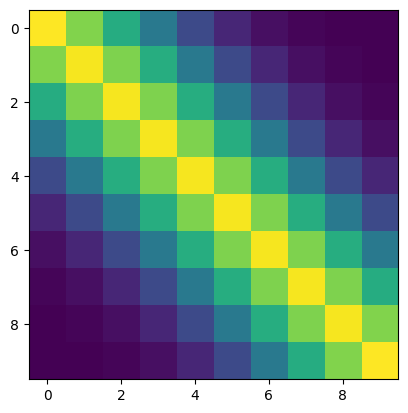

In [11]:
plt.imshow(C_s)

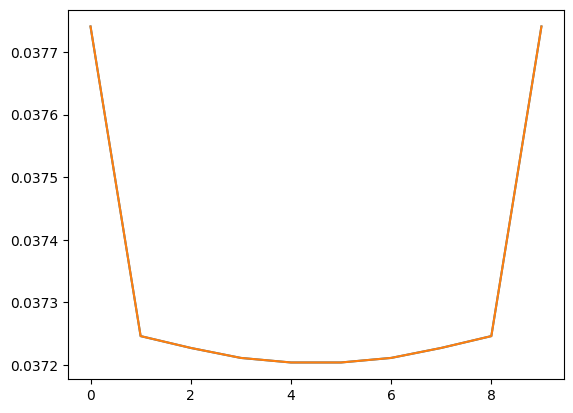

In [12]:
plt.plot(C.diagonal(), label="C diag")
plt.plot(C_s.diagonal(), label="C_s diag")